In [1]:
from pathlib import Path

import pandas as pd
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport import ForcingParameter, ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization.cost_function.seasonality_cost_function import (
    GAMSeasonalityCostFunction,
    GAMSeasonalObservation,
)
from seapopym_optimization.cost_function.simple_rmse_cost_function import DayCycle, TimeSeriesObservation
from seapopym_optimization.functional_group import NoTransportFunctionalGroup, Parameter
from seapopym_optimization.genetic_algorithm import SimpleGeneticAlgorithm, SimpleGeneticAlgorithmParameters
from seapopym_optimization.genetic_algorithm.simple_logbook import generate_logbook_with_sobol_sampling
from seapopym_optimization.model_generator import NoTransportModelGenerator


In [2]:
path_to_forcing = "../../../1_data_processing/1_1_Forcing/data/1_products/Hot_cmems_climato.zarr"
path_to_npp = "../../../1_data_processing/1_1_Forcing/data/1_products/Hot_observed_npp_climato.zarr"
path_to_obs = "../../../1_data_processing/1_1_Forcing/data/1_products/Hot_obs_zoo_climato_monthly_2002_2015.zarr"
export_file_name = "SeapoPym_GAM_HOT_climato_obs_npp_opti_all_parameters_1_group_night"

In [3]:
LATITUDE = 22.75
LONGITUDE = -158
TIME_START = "2006-01-01"
TIME_END = "2009-01-01"
STABILIZATION_TIME = 5
SAVE = True

## Loading


### Forcing


In [4]:
forcing = xr.open_zarr(path_to_forcing)
forcing = forcing.sel(time=slice(TIME_START, TIME_END))
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
forcing.load()

<xarray.Dataset> Size: 193kB
Dimensions:              (time: 1097, latitude: 1, longitude: 1, depth: 3)
Coordinates:
  * depth                (depth) int64 24B 0 1 2
  * latitude             (latitude) float64 8B 22.75
  * longitude            (longitude) int64 8B -158
  * time                 (time) datetime64[ns] 9kB 2006-01-01 ... 2009-01-01
Data variables: (12/13)
    T                    (time, latitude, longitude, depth) float64 26kB 23.8...
    U                    (time, latitude, longitude, depth) float64 26kB -0.0...
    V                    (time, latitude, longitude, depth) float64 26kB -0.0...
    mnkc_epi             (time, latitude, longitude) float64 9kB 0.2813 ... 0...
    mnkc_hmlmeso         (time, latitude, longitude) float64 9kB 0.8012 ... 0...
    mnkc_lmeso           (time, latitude, longitude) float64 9kB 2.116 ... 2.116
    ...                   ...
    mnkc_mumeso          (time, latitude, longitude) float64 9kB 0.5679 ... 0...
    mnkc_umeso           (time, latitude, longitude) float64 9kB 0.4899 ... 0...
    npp                  (time, latitude, longitude) float64 9kB 302.2 ... 302.2
    pelagic_layer_depth  (time, latitude, longitude, depth) float64 26kB 114....
    zeu                  (time, latitude, longitude) float64 9kB 76.5 ... 76.5
    zooc                 (time, latitude, longitude) float64 9kB 0.261 ... 0.261
Attributes:
    Conventions:  CF-1.7
    history:      Created on 2024-10-17
    institution:  CLS
    references:   http://www.cls.fr; http://www.seapodym.eu
    source:       SEAPODYM-LMTL 3.0.0
    title:        Global ocean low and mid trophic levels biomass content hin...

### Epipelagic layer


In [5]:
epi_layer_depth = forcing["pelagic_layer_depth"].sel(depth=0).load()
epi_layer_depth = epi_layer_depth.resample(time="1D").mean()
epi_layer_depth = epi_layer_depth.sel(time=slice(TIME_START, TIME_END))
epi_layer_depth.attrs["units"] = "meter"
epi_layer_depth = epi_layer_depth.pint.quantify()
epi_layer_depth

Magnitude,[[[114.74266258672766]] [[113.25850445781492]] [[113.67641789059907]] ... [[112.96254669775898]] [[109.84665850718022]] [[114.74266258672766]]]
Units,meter


<!-- ## Observed NPP -->


In [6]:
observed_npp = xr.open_zarr(path_to_npp)
observed_npp = observed_npp.dropna("time", how="all")
observed_npp = observed_npp.resample(time="D").interpolate("linear")
observed_npp = observed_npp.sel(time=slice(TIME_START, TIME_END))
observed_npp.load()

<xarray.Dataset> Size: 26kB
Dimensions:          (time: 1097, latitude: 1, longitude: 1)
Coordinates:
  * latitude         (latitude) float64 8B 22.75
  * longitude        (longitude) int64 8B -158
  * time             (time) datetime64[ns] 9kB 2006-01-01 ... 2009-01-01
Data variables:
    l12              (time, latitude, longitude) float64 9kB 260.2 ... 273.6
    l12_lowess_0.05  (time, latitude, longitude) float64 9kB 259.4 ... 275.4
Attributes:
    desc:     L12 multiplied by ZEU (from CMEMS).
    type:     climatology

### Observations


In [7]:
observations = xr.open_zarr(path_to_obs).load()
observations = observations.sel(latitude=LATITUDE, longitude=LONGITUDE, method="nearest")
observations = observations.resample(time="1D").mean().dropna("time")
observations = observations.pint.quantify().pint.to("mg/m^3")
observations = observations * epi_layer_depth
observations = observations.drop_vars("depth")
observations

Magnitude,[[[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[178.58649139474625]]] [[[207.78348092804256]]] [[[265.6684200378455]]] [[[283.3215285687847]]] [[[286.8754053335449]]] [[[298.4606291423159]]] [[[316.99822292914615]]] [[[307.4117305615572]]] [[[256.3939882358341]]] [[[206.1695339111292]]] [[[184.04306987771415]]]]
Units,milligram/meter2
Magnitude,[[[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[300.09769406058746]]] [[[339.1815897155657]]] [[[414.32509417720263]]] [[[391.31869310318103]]] [[[428.83910602723876]]] [[[427.7621889102778]]] [[[431.9547025535618]]] [[[408.89208174518643]]] [[[380.916096258274]]] [[[336.1242842926303]]] [[[282.197066227207]]]]
Units,milligram/meter2


Remove the X first months to let the model reach the stationary state.


In [8]:
observations = observations.sel(time=slice(TIME_START, TIME_END)).isel(time=slice(STABILIZATION_TIME, None))
observations

Magnitude,[[[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[178.58649139474625]]] [[[207.78348092804256]]] [[[265.6684200378455]]] [[[283.3215285687847]]] [[[286.8754053335449]]] [[[298.4606291423159]]] [[[316.99822292914615]]] [[[307.4117305615572]]] [[[256.3939882358341]]] [[[206.1695339111292]]] [[[184.04306987771415]]]]
Units,milligram/meter2
Magnitude,[[[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[300.09769406058746]]] [[[339.1815897155657]]] [[[414.32509417720263]]] [[[391.31869310318103]]] [[[428.83910602723876]]] [[[427.7621889102778]]] [[[431.9547025535618]]] [[[408.89208174518643]]] [[[380.916096258274]]] [[[336.1242842926303]]] [[[282.197066227207]]]]
Units,milligram/meter2


Select the kind of observation you want to use.


In [9]:
observations = [
    GAMSeasonalObservation.from_timeseries_observation(
        TimeSeriesObservation(
            name="Hot climato Day",
            observation=observations["day"],
            observation_type=DayCycle.DAY,
            observation_interval="1ME",
        )
    ),
]

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: overflow encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: invalid value encountered in matmul
  B = (u @ vh[:rank]).conj().T


Create structure for SeapoPym simulation.


In [10]:
forcing_parameters = ForcingParameter(
    temperature=ForcingUnit(forcing=forcing["T"]),
    primary_production=ForcingUnit(forcing=observed_npp["l12"]),
)

2025-06-13 17:14:18,022 :: Seapodym ::  WARNING ::
|	l12 unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.

2025-06-13 17:14:18,024 :: Seapodym ::  WARNING ::
|	l12 unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [11]:
functional_groups = [
    NoTransportFunctionalGroup(
        name="Zooplankton",
        day_layer=0,
        night_layer=0,
        energy_transfert=Parameter("D1N1_energy_transfert energy_transfert", 0.001, 0.5),
        gamma_tr=Parameter("D1N1_gamma_tr", -0.5, -0.001),
        tr_0=Parameter("D1N1_tr_0", 0, 50),
        gamma_lambda_temperature=Parameter("D1N1_gamma_lambda_temperature", 0, 0.5),
        lambda_temperature_0=Parameter("D1N1_lambda_temperature_0", 0, 1),
    ),
]

In [12]:
model_generator = NoTransportModelGenerator(forcing_parameters=forcing_parameters)

In [13]:
cost_function = GAMSeasonalityCostFunction(
    model_generator=model_generator,
    observations=observations,
    seasonal_weights=(0.5, 0.5),
    functional_groups=functional_groups,
    root_mse=True,
    normalized_mse=True,
    centered_mse=False,
)

Set the genetic algorithm meta parameters.


In [14]:
genetic_algo_parameters = SimpleGeneticAlgorithmParameters(
    MUTPB=0.30,
    INDPB=0.2,
    ETA=5,
    CXPB=0.7,
    NGEN=2,
    POP_SIZE=10,
    # cost_function_weight=(-1, -1),
    cost_function_weight=(-1,),
)

Import or create the parameters to be optimized.


In [15]:
logbook_path = Path(f"./{export_file_name}_logbook.parquet")
if logbook_path.exists():
    logbook = pd.read_parquet(logbook_path)
else:
    logbook = generate_logbook_with_sobol_sampling(
        functional_group_parameters=functional_groups,
        sample_number=256,
        # sample_number=1,
        fitness_name=["Hot climato"],
        # fitness_name=["Hot climato Day", "Hot climato Night"],
    )
logbook

category                                                                       Parametre  \
name                                              D1N1_energy_transfert energy_transfert   
Generation Is_From_Previous_Generation Individual                                          
0          False                       0                                        0.139574   
                                       1                                        0.221743   
                                       2                                        0.139574   
                                       3                                        0.139574   
                                       4                                        0.139574   
...                                                                                  ...   
                                       1787                                     0.137695   
                                       1788                                     0.137695   
                                       1789                                     0.137695   
                                       1790                                     0.137695   
                                       1791                                     0.497478   

category                                                                     \
name                                              D1N1_lambda_temperature_0   
Generation Is_From_Previous_Generation Individual                             
0          False                       0                           0.756586   
                                       1                           0.756586   
                                       2                           0.379984   
                                       3                           0.756586   
                                       4                           0.756586   
...                                                                     ...   
                                       1787                        0.972096   
                                       1788                        0.078676   
                                       1789                        0.078676   
                                       1790                        0.078676   
                                       1791                        0.972096   

category                                                                         \
name                                              D1N1_gamma_lambda_temperature   
Generation Is_From_Previous_Generation Individual                                 
0          False                       0                               0.319426   
                                       1                               0.319426   
                                       2                               0.319426   
                                       3                               0.486100   
                                       4                               0.319426   
...                                                                         ...   
                                       1787                            0.208892   
                                       1788                            0.387349   
                                       1789                            0.208892   
                                       1790                            0.208892   
                                       1791                            0.387349   

category                                                                    \
name                                               D1N1_tr_0 D1N1_gamma_tr   
Generation Is_From_Previous_Generation Individual                            
0          False                       0           48.656031     -0.030179   
                                       1           48.656031     -0.030179   
                                       2           

Finaly, create the Genetic Algorithm.


In [16]:
client = Client()
genetic_algo = SimpleGeneticAlgorithm(
    meta_parameter=genetic_algo_parameters,
    cost_function=cost_function,
    client=client,
    logbook=logbook,
    save=logbook_path,
)

And watch the magic on the Dask dashboard :


In [17]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61762,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:61774,Total threads: 3
Dashboard: http://127.0.0.1:61777/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:61765,


## Run the optimization


In [18]:
viewer = genetic_algo.optimize()

Some individuals in the logbook have no fitness values. Re-evaluating the population.
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: overflow encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: invalid value encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/S

## Optimization statistics


In [19]:
viewer.hall_of_fame().iloc[:10]

category                                                                       Parametre  \
name                                              D1N1_energy_transfert energy_transfert   
Generation Is_From_Previous_Generation Individual                                          
0          False                       716                                      0.427800   
                                       1294                                     0.467136   
                                       1674                                     0.225279   
                                       1427                                     0.381568   
                                       1722                                     0.406366   
                                       1726                                     0.406366   
                                       1727                                     0.406366   
                                       12                                       0.474856   
                                       7                                        0.474856   
                                       11                                       0.474856   

category                                                                     \
name                                              D1N1_lambda_temperature_0   
Generation Is_From_Previous_Generation Individual                             
0          False                       716                         0.206111   
                                       1294                        0.958356   
                                       1674                        0.270202   
                                       1427                        0.816353   
                                       1722                        0.883625   
                                       1726                        0.883625   
                                       1727                        0.883625   
                                       12                          0.254461   
                                       7                           0.254461   
                                       11                          0.254461   

category                                                                         \
name                                              D1N1_gamma_lambda_temperature   
Generation Is_From_Previous_Generation Individual                                 
0          False                       716                             0.064080   
                                       1294                            0.001999   
                                       1674                            0.019694   
                                       1427                            0.005770   
                                       1722                            0.007166   
                                       1726                            0.007166   
                                       1727                            0.007166   
                                       12                              0.070688   
                                       7                               0.070688   
                                       11                              0.070688   

category                                                                    \
name                                               D1N1_tr_0 D1N1_gamma_tr   
Generation Is_From_Previous_Generation Individual                            
0          False                       716         11.448772     -0.108701   
                                       1294        26.207673     -0.320787   
                                       1674        39.592443     -0.450318   
                                       1427        48.674498     -0.413546   
                                       1722        26.120073     -0.291259   
                                       1726        44.779518     -0.291

In [20]:
viewer.fitness_evolution(points="all")

In [21]:
viewer.parameters_standardized_deviation()

In [22]:
viewer.shannon_entropy(bins=100_000)

In [23]:
fig = viewer.box_plot(3, nbest=500)
fig.show()

In [24]:
fig = viewer.parallel_coordinates(nbest=500, reversescale=True, unselected_opacity=0.05, uniformed=True)

for group in fig:
    display(group)

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning:

n_quantiles (1000) is greater than the total number of samples (500). n_quantiles is set to n_samples.



In [25]:
best_simulations = viewer.simulation_manager.run_first(3)

In [26]:
import numpy as np


np.log10(best_simulations[0].squeeze())

<xarray.DataArray <ForcingLabels.biomass: 'biomass'> (time: 1097)> Size: 9kB
array([-3.95350315, -3.81105268, -3.76572947, ..., -3.72094988,
       -3.72460439, -3.72162602], shape=(1097,))
Coordinates:
  * time              (time) datetime64[ns] 9kB 2006-01-01 ... 2009-01-01
    latitude          float64 8B 22.75
    longitude         int64 8B -158
    functional_group  int64 8B 0
Attributes:
    long_name:    biomass
    units:        kilogram / meter ** 2
    description:  The biomass of the recruited individuals.

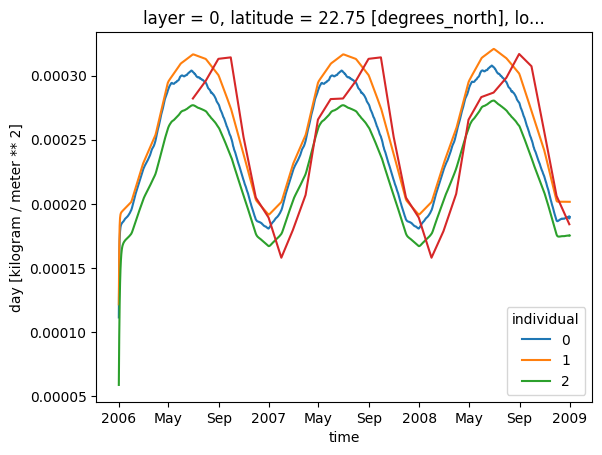

In [27]:
best_simulations.squeeze().plot.line(x="time")
observations[0].observation.squeeze().plot.line(label="Day observation")